# Time Series Utils - Forecasting example

###### Sales forecasting dataset (Kaggle)  https://www.kaggle.com/c/competitive-data-science-predict-future-sales

### 0 - Setup

###### Import pckgs 

In [2]:
from ts_utils import *
import warnings
warnings.filterwarnings("ignore")

###### Import data

In [3]:
dtf = pd.read_csv('data.csv')
dtf.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
dtf["date"] = pd.to_datetime(dtf['date'], format='%d.%m.%Y')

In [5]:
ts = dtf.groupby("date")["item_cnt_day"].sum().rename("sales")
ts.head()

date
2013-01-01    1951.0
2013-01-02    8198.0
2013-01-03    7422.0
2013-01-04    6617.0
2013-01-05    6346.0
Name: sales, dtype: float64

In [6]:
ts.tail()

date
2015-10-27    1551.0
2015-10-28    3593.0
2015-10-29    1589.0
2015-10-30    2274.0
2015-10-31    3104.0
Name: sales, dtype: float64

### 1 - TimeSeries Analysis

###### Check for:
- Seasonality
- Trend
- Stationarity

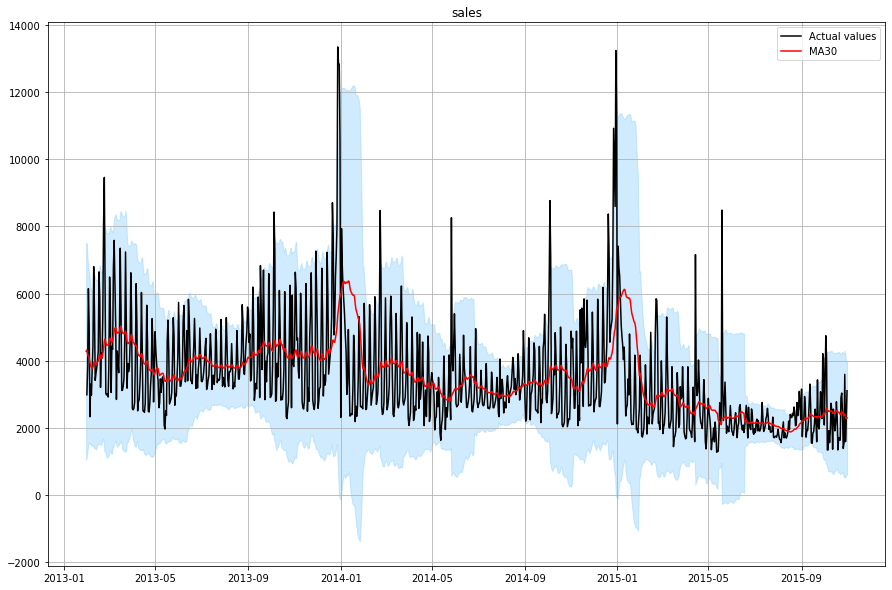

In [7]:
plot_ts(ts, plot_ma=True, plot_intervals=True, window=30, figsize=(15,10))

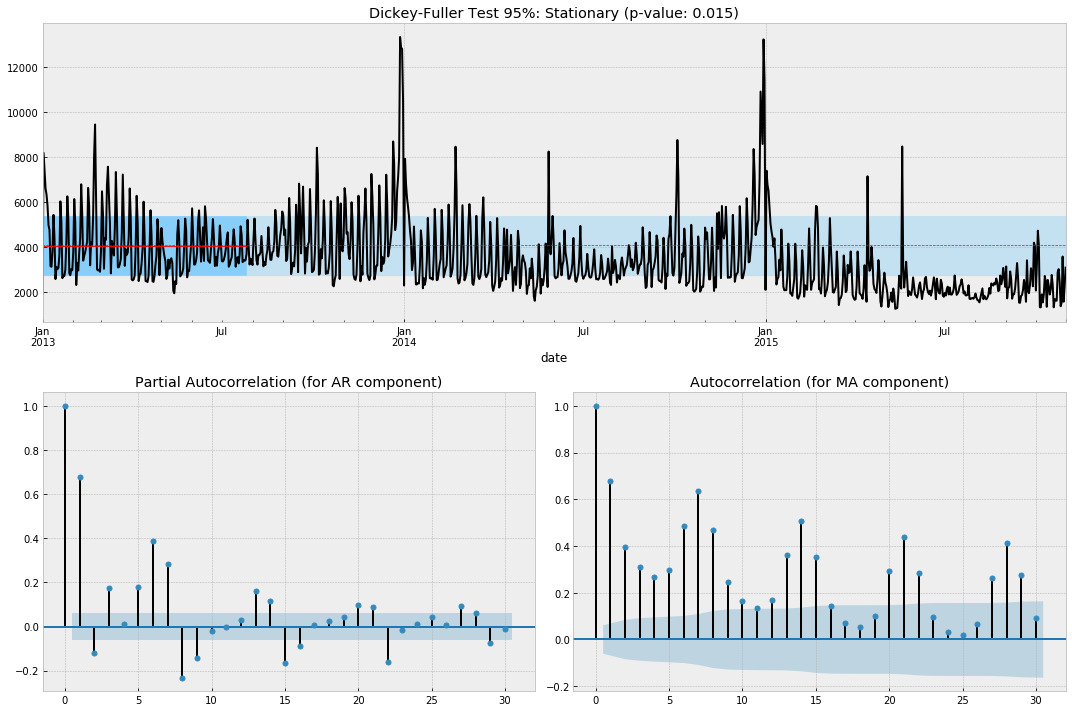

In [8]:
test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30, figsize=(15,10))

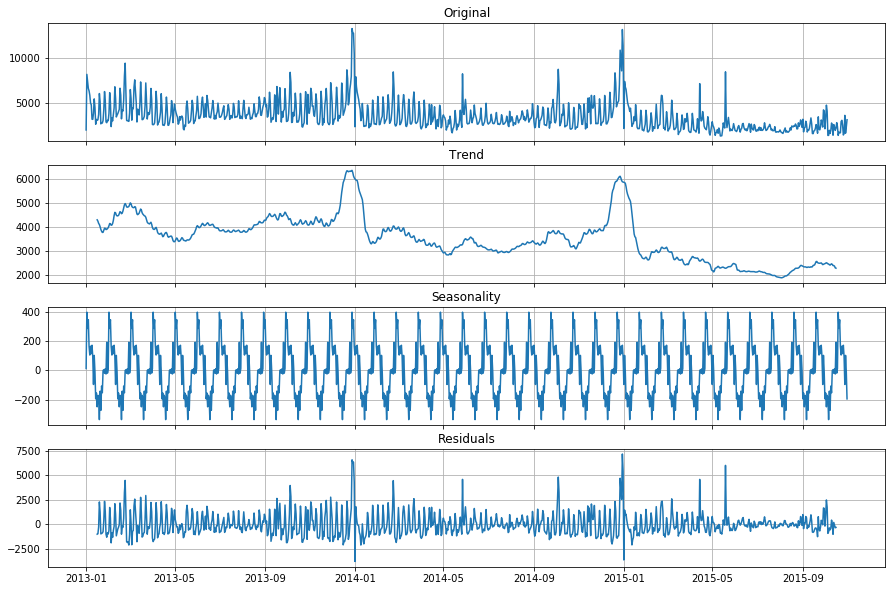

In [9]:
dic_decomposed = decompose_ts(ts, s=30, figsize=(15,10))

### 2 - Baseline

###### Holtwinters

Seasonal parameters: None Seasonality every 30 observations
--- splitting at index:  827  ---


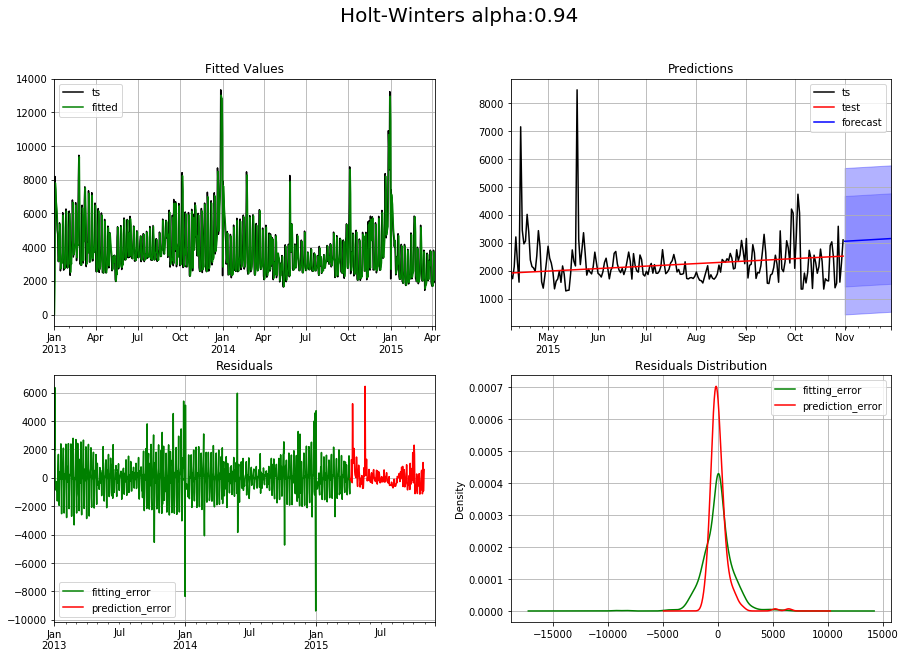

error_mean: 55.0  | error_std: 828.0  | mae: 499.0  | mape: 21.0 %  | mse: 684682.0  | rmse: 827.0


In [10]:
holtwinters, model = fit_expsmooth(ts, trend="additive", seasonal=None, s=30, alpha=0.94, test=0.2, 
                                   pred_ahead=30, figsize=(15,10))

### 3 - Model Desing & Testing

###### Arima

In [11]:
# takes quite a while
find_best_sarimax(ts, seasonal=True, stationary=False, s=30, exog=None,
                  max_p=7, max_d=1, max_q=7, 
                  max_P=1, max_D=1, max_Q=1)

best model --> (p, d, q): (7, 1, 7)  and  (P, D, Q, s): (0, 0, 1, 30)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1034
Model:             SARIMAX(7, 1, 7)x(0, 0, 1, 30)   Log Likelihood               -8468.803
Date:                            Tue, 04 Feb 2020   AIC                          16971.607
Time:                                    13:38:11   BIC                          17055.591
Sample:                                         0   HQIC                         17003.476
                                           - 1034                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -5.1555     17.925     -0.288      0.774     -40.287      29.976
ar.L1         -0.3738      0.042     -8.912      0.000      -0.456      -0.292
ar.L2         -0.3915      0.035    -11.309      0.000      -0.459      -0.324
ar.L3         -0.3883      0.040     -9.823      0.000      -0.466      -0.311
ar.L4         -0.3803      0.036    -10.663      0.000      -0.450      -0.310
ar.L5         -0.4022      0.036    -11.252      0.000      -0.472      -0.332
ar.L6         -0.3659      0.039     -9.368      0.000      -0.442      -0.289
ar.L7          0.5872      0.032     18.589      0.000       0.525       0.649
ma.L1          0.0378      0.039      0.960      0.337      -0.039       0.115
ma.L2          0.0379      0.032      1.193      0.233      -0.024       0.100
ma.L3          0.0705      0.031      2.249      0.025       0.009       0.132
ma.L4          0.0170      0.032      0.529      0.597      -0.046       0.080
ma.L5          0.0590      0.037      1.585      0.113      -0.014       0.132
ma.L6          0.0245      0.036      0.674      0.500      -0.047       0.096
ma.L7         -0.8046      0.032    -25.485      0.000      -0.867      -0.743
ma.S.L30      -0.0145      0.045     -0.319      0.750      -0.103       0.075
sigma2      8.005e+05      0.008   1.05e+08      0.000       8e+05       8e+05
===================================================================================
Ljung-Box (Q):                       52.64   Jarque-Bera (JB):             14317.90
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.56e+22. Standard errors may be unstable.
"""

Trend parameters: trend is additive and d=1
Seasonal parameters: Seasonality every 30 observations
Exog parameters: Not given
--- splitting at index:  827  ---


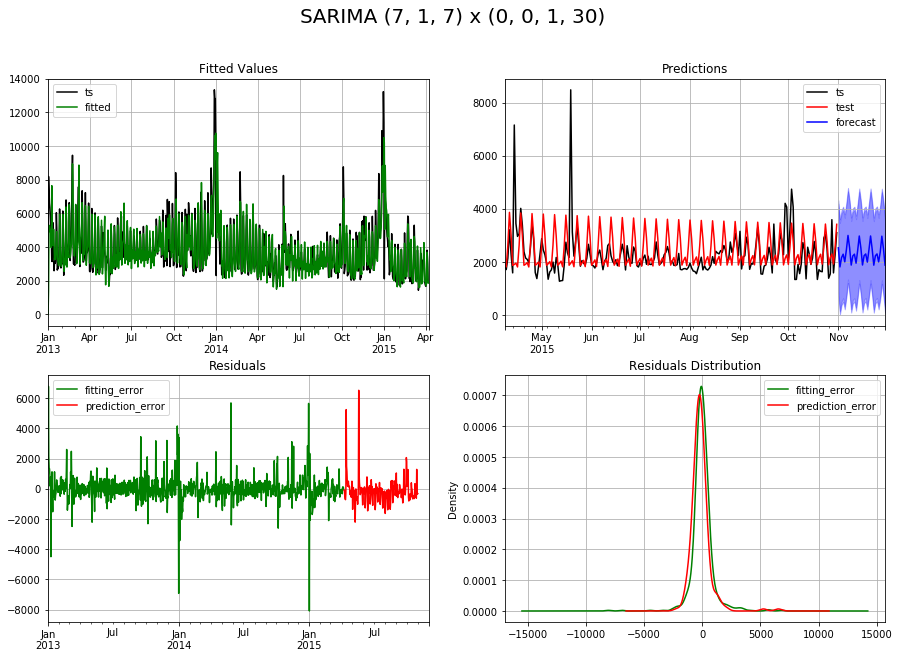

error_mean: -161.0  | error_std: 845.0  | mae: 533.0  | mape: 22.0 %  | mse: 737184.0  | rmse: 859.0


In [12]:
arima, model = fit_sarimax(ts, order=(7,1,7), trend="additive", seasonal_order=(0,0,1,30), 
                           exog=None, test=0.2, figsize=(15,10),
                           pred_exog=None, pred_ahead=30)

###### Rnn

--- splitting at index:  827  ---


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                16200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 16,251
Trainable params: 16,251
Non-trainable params: 0
_________________________________________________________________
None
--- training ---


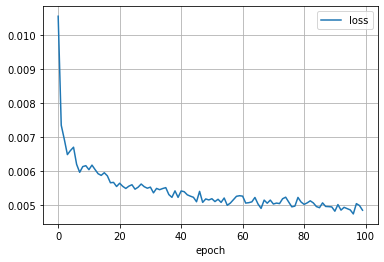

--- testing ---


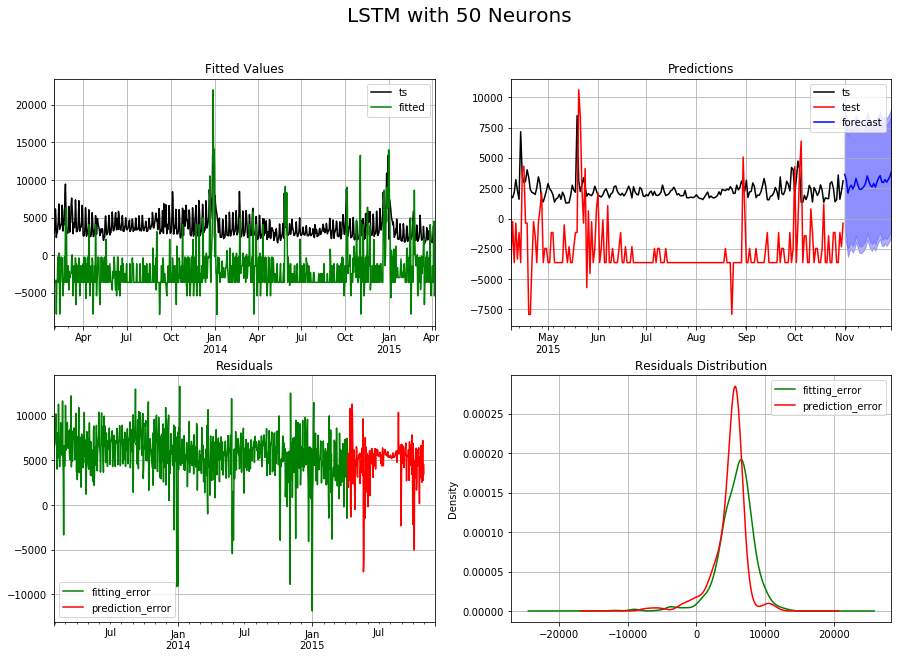

error_mean: 4805.0  | error_std: 2404.0  | mae: 5068.0  | mape: 234.0 %  | mse: 28841815.0  | rmse: 5370.0


In [13]:
lstm, model = fit_lstm(ts, exog=None, s=30, neurons=50, batch_size=1, epochs=100, test=0.2, 
                       ahead=30, freq="D", figsize=(15,10))

###### Prophet

In [14]:
dtf_ts = ts.reset_index().rename(columns={"date":"ds", "sales":"y"})
dtf_ts.head()

,ds,y
0,2013-01-01,1951.0
1,2013-01-02,8198.0
2,2013-01-03,7422.0
3,2013-01-04,6617.0
4,2013-01-05,6346.0


In [16]:
prophet, model = fit_prophet(dtf_ts, freq="D", preds_ahead=5, figsize=(15,10),
                             growth="linear", changepoints=None, n_changepoints=25,
                             yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality="auto", 
                             seasonality_mode='additive',
                             holidays=None, lst_exog=None, pred_exog=None)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--- splitting at index:  827  ---
